In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
df_aaindex = pd.read_csv('data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
test = pd.read_csv('data/df_detect_peptide_test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

In [31]:
train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
210101,R.MDKVHSEAER.L,QQKVLQQRMDKVHSE,KVHSEAERLEARFQD,VLQQRMDKVHSEAER,-,sp|Q96M63|CC114_HUMAN,MDKVHSEAER,0


In [51]:
def get_data(df):
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYVZ'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq] + [[0]*21]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq]
               for seq in df.En.values]
    ec_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq]
               if seq != '-' else [[0]*21 for _ in range(15)]
               for seq in df.E1.values]
    e2_data = [[[1 if aa == a else 0 for a in 'ARNDCQEGHILKMFPSTWYVZ'] for aa in seq]
               if seq != '-' else [[0]*21 for _ in range(15)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

In [54]:
aa_train, pep_train, en_train, ec_train, e1_train, e2_train, y_train = get_data(train)

aa_val, pep_val, en_val, ec_val, e1_val, e2_val, y_val = get_data(val)

aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data(test)

In [55]:
print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, y_train.shape)

print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, y_val.shape)

print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(215352, 40) (215352, 30, 21) (215352, 15, 21) (215352, 15, 21) (215352, 15, 21) (215352, 15, 21) (215352,)
(53838, 40) (53838, 30, 21) (53838, 15, 21) (53838, 15, 21) (53838, 15, 21) (53838, 15, 21) (53838,)
(67298, 40) (67298, 30, 21) (67298, 15, 21) (67298, 15, 21) (67298, 15, 21) (67298, 15, 21) (67298,)


# Train

In [8]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*8)])
    except RuntimeError as e:
        print(e)

In [9]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [69]:
input1 = tf.keras.layers.Input(shape=((30,21,)))  # peptide with zero padding
input2 = tf.keras.layers.Input(shape=((40,)))  # peptide info
input3 = tf.keras.layers.Input(shape=((15,21,)))  # N term info
input4 = tf.keras.layers.Input(shape=((15,21,)))  # C term info
input5 = tf.keras.layers.Input(shape=((15,21,)))  # miss1 term info
input6 = tf.keras.layers.Input(shape=((15,21,)))  # miss2 term info


lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input1)
net_lstm = tf.keras.layers.Dense(16, activation='relu')(lstm1)

net_dense1 = tf.keras.layers.Dense(32, activation='relu')(input2)

digest_n = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input3)
net_n = tf.keras.layers.Dense(16, activation='relu')(digest_n)
digest_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input4)
net_c = tf.keras.layers.Dense(16, activation='relu')(digest_c)
digest_m1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input5)
net_m1 = tf.keras.layers.Dense(16, activation='relu')(digest_m1)
digest_m2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(input6)
net_m2 = tf.keras.layers.Dense(16, activation='relu')(digest_m2)

merge = tf.keras.layers.concatenate([net_lstm, 
                                     net_dense1,
                                    net_n,
                                    net_c,
                                    net_m1,
                                    net_m2])

net1 = tf.keras.layers.Dense(128, activation='relu')(merge)
net1_drop = tf.keras.layers.Dropout(0.3)(net1)
# net2 = tf.keras.layers.Dense(64, activation='relu')(net1)
net3 = tf.keras.layers.Dense(64, activation='relu')(net1_drop)  # 256도해보자.

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net3)

model_high = tf.keras.Model(inputs=[input1, input2,
                              input3, input4,
                              input5, input6],
                       outputs=[output])

model_high.summary()

model_high.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=20)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 30, 21)]     0                                            
__________________________________________________________________________________________________
input_45 (InputLayer)           [(None, 15, 21)]     0                                            
__________________________________________________________________________________________________
input_46 (InputLayer)           [(None, 15, 21)]     0                                            
__________________________________________________________________________________________________
input_47 (InputLayer)           [(None, 15, 21)]     0                                            
____________________________________________________________________________________________

In [70]:
history = model_high.fit([pep_train, aa_train, en_train, ec_train, e1_train, e2_train],
                    y_train, 
                    epochs=250,
                    batch_size=32,
                    validation_data=([pep_val, aa_val, en_val, ec_val, e1_val, e2_val], y_val),
                    callbacks=[es])

Epoch 1/250
6730/6730 [==============================] - 126s 17ms/step - loss: 2.3212 - accuracy: 0.6103 - val_loss: 0.4943 - val_accuracy: 0.7609
Epoch 2/250
6730/6730 [==============================] - 111s 17ms/step - loss: 0.5053 - accuracy: 0.7566 - val_loss: 0.4601 - val_accuracy: 0.7816
Epoch 3/250
6730/6730 [==============================] - 112s 17ms/step - loss: 0.4694 - accuracy: 0.7777 - val_loss: 0.4450 - val_accuracy: 0.7909
Epoch 4/250
6730/6730 [==============================] - 112s 17ms/step - loss: 0.4521 - accuracy: 0.7880 - val_loss: 0.4381 - val_accuracy: 0.7961
Epoch 5/250
6730/6730 [==============================] - 111s 17ms/step - loss: 0.4398 - accuracy: 0.7958 - val_loss: 0.4302 - val_accuracy: 0.8013
Epoch 6/250
6730/6730 [==============================] - 112s 17ms/step - loss: 0.4316 - accuracy: 0.8000 - val_loss: 0.4310 - val_accuracy: 0.8007
Epoch 7/250
6730/6730 [==============================] - 114s 17ms/step - loss: 0.4239 - accuracy: 0.8041 - val_

6730/6730 [==============================] - 113s 17ms/step - loss: 0.3649 - accuracy: 0.8392 - val_loss: 0.3903 - val_accuracy: 0.8307
Epoch 57/250
6730/6730 [==============================] - 112s 17ms/step - loss: 0.3653 - accuracy: 0.8386 - val_loss: 0.3920 - val_accuracy: 0.8311
Epoch 58/250
6730/6730 [==============================] - 109s 16ms/step - loss: 0.3663 - accuracy: 0.8391 - val_loss: 0.3911 - val_accuracy: 0.8299
Epoch 59/250
6730/6730 [==============================] - 113s 17ms/step - loss: 0.3653 - accuracy: 0.8389 - val_loss: 0.3835 - val_accuracy: 0.8322
Epoch 60/250
6730/6730 [==============================] - 113s 17ms/step - loss: 0.3649 - accuracy: 0.8383 - val_loss: 0.3850 - val_accuracy: 0.8323
Epoch 61/250
6730/6730 [==============================] - 113s 17ms/step - loss: 0.3632 - accuracy: 0.8385 - val_loss: 0.3818 - val_accuracy: 0.8319
Epoch 62/250
6730/6730 [==============================] - 112s 17ms/step - loss: 0.3649 - accuracy: 0.8375 - val_loss: 

Epoch 111/250
6730/6730 [==============================] - 141s 21ms/step - loss: 0.3488 - accuracy: 0.8469 - val_loss: 0.3824 - val_accuracy: 0.8332
Epoch 112/250
6730/6730 [==============================] - 137s 20ms/step - loss: 0.3458 - accuracy: 0.8495 - val_loss: 0.3818 - val_accuracy: 0.8323
Epoch 113/250
6730/6730 [==============================] - 136s 20ms/step - loss: 0.3477 - accuracy: 0.8472 - val_loss: 0.3829 - val_accuracy: 0.8333
Epoch 114/250
6730/6730 [==============================] - 137s 20ms/step - loss: 0.3475 - accuracy: 0.8480 - val_loss: 0.3872 - val_accuracy: 0.8306
Epoch 115/250
6730/6730 [==============================] - 138s 20ms/step - loss: 0.3465 - accuracy: 0.8474 - val_loss: 0.3810 - val_accuracy: 0.8334
Epoch 116/250
6730/6730 [==============================] - 141s 21ms/step - loss: 0.3470 - accuracy: 0.8483 - val_loss: 0.3875 - val_accuracy: 0.8325
Epoch 117/250
6730/6730 [==============================] - 136s 20ms/step - loss: 0.3447 - accuracy:

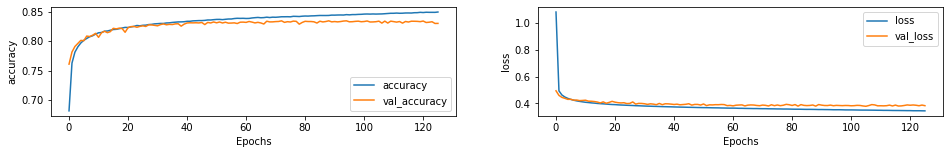

In [71]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# eval

2104/2104 [==============================] - 19s 9ms/step - loss: 0.3787 - accuracy: 0.8315
Test Loss: 0.37874361872673035
Test Accuracy: 0.8315402865409851
              precision    recall  f1-score   support

           0       0.85      0.80      0.83     33706
           1       0.81      0.86      0.84     33592

    accuracy                           0.83     67298
   macro avg       0.83      0.83      0.83     67298
weighted avg       0.83      0.83      0.83     67298

rf auc : 0.9132060997321204


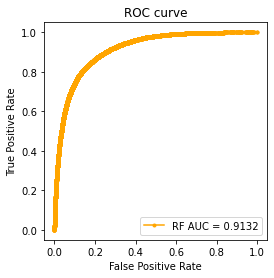

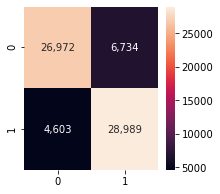

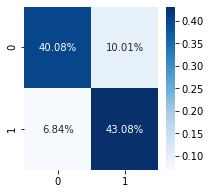

In [72]:
test_loss, test_acc = model_high.evaluate([pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# other model
  - 2019Bioinformatics : DeepMSpeptide 
    - Acc : 0.809, AUC : 0.871
  - 2019ACS : AP3 
    - Acc : 0.790, AUC : 0.875
  - 2021ACS : PepFormer
    - Acc : 0.832, AUC : 0.906

* 2021KSBI : ?
  - Acc : 0.815, AUC : 0.895